# **Simulation of Uncertainty-Aware Path Planning for Navigation on Road Networks Using Augmented MDPs**

**Course**:  AER1516 - Motion Planning for Robotics

**Professor**: Dr. Jonathan Kelly

**Date**: 24 March 2022

**Team**: Vishal Kanna Anand, Andrew Constantinescu, Sugumar Prabhakaran

**References**:  
[1]  L. Nardi and C. Stachniss, "Uncertainty-Aware Path Planning for Navigation on Road Networks Using Augmented MDPS," in *2019 International Conference on Robotics and Automation (ICRA)*, May 20-24, 2019, Montreal, Canada [Online]. Available: IEEE Xplore, https://ieeexplore.ieee.org/document/8794121. [Accessed: 01 March 2022].

[2]  O. Vysotska and C. Stachniss, "Improving SLAM by Exploiting Building Information from Publicly Available Maps and Localization Priors," PFG- Journal of Photogrammetry, Remote Sensing and Geoinformation Science, vol. 85, pp. 53-65, 21 February 2017. [Online]. Available:  Springer Link, https://link.springer.com/article/10.1007/s41064-017-0006-3.  [Accessed: 08 March 2022].

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from scipy.stats import multivariate_normal
from scipy.stats.mvn import mvnun

## **Introduction**

This simulation is intended to verify the results from the paper by Nardi and Stachniss [1].  The paper proposes a way to incorporate localization uncertainty into path planning for navigation in road networks.  

This simulation will walk through step by step all the components from the paper to generate results.

## **Methodology**

### **Step 1. Localizability Map Z**

The paper uses the method proposed by Vysotska and Stachniss [2] to calculate the prior.  At each location of the map, a virtual scan is simulated by ray-casting the map.  

* Vysotska describes the result as a visiblity map based on OpenStreet Map (OSM) data. Need to specify function to measure the likelihood of obtaining a certain laser scan given a pose.

<p align='center'>
$p(z_j) ∼ N(c_j, \sigma_l)$
</p>

* each beam $z_j$ is independent of each other with its noise distributed as a gaussian. $c_j$ is the closest points in the building corresponding to endpoints of beam z_j.

<p align='center'>
<img src='https://drive.google.com/uc?export=view&id=1yXEME2jqbbNSgWXrAUcgCQCLh6gSy5fC'>
</p>

* A simulated scan is generated by ray-cast operation in the maps from OSM at every potential pose $x_i$ in the map.  Small perturbances to the pose $x_i = [x, y, \theta]$ are used to generate a set $S$.

* The error for a pose configuration is estimated using the sum of squared errors $e(z_j)$ of each individual beam ($z_j$) of the scan to the corresponding closest point on the building ($c_j$).  

<p align='center'>
$e(z_j) = (z_j - c_j)^2$
</p>

* The probability of taking a virtual measurement at a given configuration $x_j$ is is approximated as:

<p align='center'>
$p(x_j) = exp(-\frac{\sum e(z_j)}{2N\sigma_l^2})$
</p>

* Finally the covariance matrix (the uncertainty of the pose) is obtained as follows:

<p align='center'>
$cov(x_i) = \sum_{x_j \in S} p(x_j)(x_j-q_{xi})(x_j-q_{xi})^T$
</p>

In this case $q_{xi}$ is the coordinates of the query pose.

* **Output**:  The result is a covariance matrix (prior) for each traversable cell in X, known as the localizability map Z.


**Sensor model (simulated laser scan)**:

<p align='left'>
$\text{(1)} \qquad p(z_j) ∼ N(c_j, \sigma_l)$
</p>

 * $c_j$: closest point on building,  $\sigma_l$: variance of laser scan, $z_j$: end-point of individual beam

**Probability of virtual measurement at configuration** $x_j$:

<p align='left'>
$\text{(2)} \qquad p(x_j) = exp(-\frac{\sum e(z_j)}{2N\sigma_l^2})$
</p>

 * $N$: size of laser scan array, $\sum e(z_j)$: sum of squared differences between $z_j$ and $c_j$


**Covariance matrix (uncertainty) of pose** $x_i$:

<p align='left'>
$\text{(3)} \qquad cov(x_i) = \sum_{x_j \in S} p(x_j)(x_j-q_{x_i})(x_j-q_{x_i})^T$
</p>

 * $q_{x_i}$: configuration of pose $x_i$, $S$: set of all poses similar to $x_i$

### **Step 2 - Augmented States (S)**

**Set of Augmented States**:

$\text{(4)} \qquad S = \{s=(v,\sigma^2)| v \in V, \sigma^2 \in W\}$

where:
* $s$: augmented state that is normally distributed: $s \sim N(v, \Sigma)$
* $V$: set of all road intersections
* $W$: set of all variances
*$\Sigma$: covariance matrix:  $\Sigma = \begin{bmatrix}
    \sigma^2 & 0 \\
    0 & \sigma^2
  \end{bmatrix}$

The augmented state s is defined over the discrete space $X$ as the probability mass function: $p(x|s)$

Set of Augmented States (S) = [(array([0.5, 0.5]), 0), (array([3.5, 0.5]), 0.5), (array([8.5, 0.5]), 1), (array([12.5,  0.5]), 0.1)]


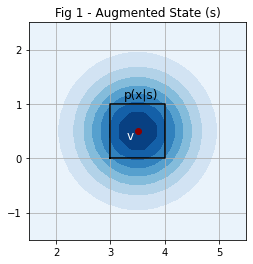

In [2]:
#vertices/ intersections
V = np.array([[0.5, 0.5], [3.5, 0.5], [8.5, 0.5], [12.5, 0.5]])

# variances
var = [0, 0.5, 1, 0.1]

S = []
# augmented states
for i, v in enumerate(V):
    S.append((v, var[i]))

print("Set of Augmented States (S) =", S)

# need X, Y, Z for each p(x=v_j| N(v_j, Sigma))  
def determine_points(mu, N=5, end=2):
    X = np.linspace(mu[0]-end, mu[0]+end, N)
    Y = np.linspace(mu[1]-end, mu[1]+end, N)
    X,Y = np.meshgrid(X,Y)
    pos = np.empty(X.shape + (2,))
    pos [:,:,0] = X
    pos [:,:,1] = Y
    return X, Y, pos

fig, ax = plt.subplots(figsize=(4,4))

# building layout
#building1 = plt.Rectangle((1,1), 7, 2, fc='grey')
#plt.gca().add_patch(building1)

X, Y, pos = determine_points(V[1], 20)
Sigma = np.array([[var[1],0],[0,var[1]]])
Z = multivariate_normal.pdf(pos, V[1], Sigma)
ax.contourf(X, Y, Z, cmap='Blues')

# plot intersections/vertices
# ax.plot([1.5, 5.5], [0, 0], c='black')
# ax.plot([1.5, 5.5], [1, 1], c='black')
# ax.plot([3, 3], [0, 1], c='black')
ax.plot([3,4,4,3,3], [0,0,1,1,0], c='black')
ax.scatter([3.5], [0.5], c='darkred', marker='o')

# add annotation to the intersections/vertices
intersections = ['v', 'vA', 'vB', 'vC']
locations = [(0, 0), (3, 0), (8, 0), (12, 0)]
plt.annotate('v', [3.3,0.35], c='white', size='12')
plt.annotate('p(x|s)', [3.25,1.1], c='black', size='12')

# final formatting
ax.grid()
plt.xlim([0,5])
plt.ylim([0,3])
ax.set_xticks(np.arange(0, 6))
ax.set_yticks(np.arange(-1,3))
plt.title('Fig 1 - Augmented State (s)')
ax.axis('scaled')
plt.savefig('figure_1_graph.png', dpi=550)
plt.show()

### **Step 3 - Actions (A)**

For our example, our action space ($A$) is only going to be defined as the four cardinal arrows:

$\text{(5)}\quad A = \{\uparrow,\downarrow, \leftarrow, \rightarrow \}$

### **Step 4 - Transition Function (T) Considering Position Uncertainty**

#### <u>Part 1 - Compute robot's position posterior starting at an intersection</u>

In part 1, we compute the robot's position posterior $p(x|v,a)$ without considering any uncertainty in the input position for all $v \in V$ and $a \in A$

There is a complex process to combine the covariance matrix obtained in step 1 (from Localizability Map Z) with the Extended Kalman Filter (EKF) prediction step.

The posterior belief about the robot's position of navigating from intersection $v_i$ to $v_j$ is the Gaussian distribution: $N(v_j, \Sigma_{j|i,a})$.  
 
 The probability that the robot detects $v_j$ after starting at $v_i$ and taking action $a$ is modelled as:

$p_{detect}(v_j|v_i, a)= p(x=v_j|N(v_j, \Sigma_{j|i,a}))$

where $N(v_j, \Sigma_{j|i,a})$ is a gaussian distribution

See image below for graphical representation of the $p_{detect}(v_j|v_i, a)$.

**Probability of detecting intersection**:

$\text{(6)}\qquad p_{detect}(v_j|v_i, a)= p(x=v_j|N(v_j, \Sigma_{j|i,a}))$

* $x$: intersection at a discrete grid
* $N(v_j, \Sigma_{j|i,a})$: gaussian distribution centered at intersection $v_j$



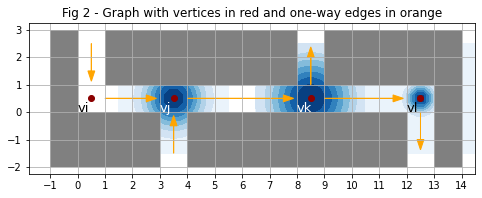

In [3]:
fig, ax = plt.subplots(figsize=(8,5))

# building layout
building1 = plt.Rectangle((1,1), 7, 2, fc='grey')
building2 = plt.Rectangle((4, -2), 8, 2, fc='grey')
building3 = plt.Rectangle((9,1), 5, 2, fc='grey')
building4 = plt.Rectangle((13,-2), 1, 3, fc='grey')
building5 = plt.Rectangle((-1,-2), 1, 5, fc='grey')
building6 = plt.Rectangle((0,-2), 3, 2, fc='grey')
plt.gca().add_patch(building1)
plt.gca().add_patch(building2)
plt.gca().add_patch(building3)
plt.gca().add_patch(building4)
plt.gca().add_patch(building5)
plt.gca().add_patch(building6)

# one-way streets
plt.arrow(0.5, 2.5, 0, -1, head_width=0.25, color='orange')
plt.arrow(8.5, 1, 0, 1, head_width=0.25, color='orange')
plt.arrow(3.5, -1.5, 0, 1, head_width=0.25, color='orange')
plt.arrow(12.5, 0, 0, -1, head_width=0.25, color='orange')
plt.arrow(1, 0.5, 1.5, 0, head_width=0.25, color='orange')
plt.arrow(4, 0.5, 3.5, 0, head_width=0.25, color='orange')
plt.arrow(9, 0.5, 2.5, 0, head_width=0.25, color='orange')

#plot gaussian distribution for each intersection/vertex:
# a = 
# my_cmap = plt.cm.Blues(np.arange(plt.cm.Blues.N))
# my_cmap[:,0:3] *= a 
# my_cmap = ListedColormap(my_cmap)

for i, v in enumerate(V):
    if i == 0:
        continue
    X, Y, pos = determine_points(v, 20)
    Sigma = np.array([[var[i],0],[0,var[i]]])
    Z = multivariate_normal.pdf(pos, v, Sigma)
    plt.contourf(X, Y, Z, cmap='Blues')

# plot intersections/vertices
plt.scatter([0.5, 3.5, 8.5, 12.5], [0.5, 0.5, 0.5, 0.5], 
            c='darkred', marker='o')

# add annotation to the intersections/vertices
intersections = ['vi', 'vj', 'vk', 'vl']
locations = [(0, 0), (3, 0), (8, 0), (12, 0)]
for i, location in enumerate(locations):
    if i==2 or i==1:
        plt.annotate(intersections[i], location, size=13, color='white')
    else:
        plt.annotate(intersections[i], location, size=13)

# final formatting
plt.grid()
plt.xticks(np.arange(-1, 15))
plt.yticks(np.arange(-2,4))
plt.title('Fig 2 - Graph with vertices in red and one-way edges in orange')
plt.axis('scaled')
plt.savefig('figure_2_graph.png', dpi=550)
plt.show()

In [4]:
def compute_prob(v, var, integration_range):
    def pdf(*args):
        x = np.array(args)
        return multivariate_normal.pdf(x, mean=mean, cov=cov)
    X, Y, pos = determine_points(v, 20)
    mean = v
    cov = np.array([[var, 0],[0, var]])
    output, _ = nquad(pdf, integration_range)
    return output

integration_range = [[[0,1],[0,1]],[[3,4],[0,1]],[[8,9],[0,1]], [[12,13],[0,1]]]

for i, v in enumerate(V):
    if i ==0:
        continue
    result = compute_prob(v, var[i], integration_range[i])
    print("p_detect v_",i, '= ', round(result, 3))

p_detect v_ 1 =  0.271
p_detect v_ 2 =  0.147
p_detect v_ 3 =  0.785


**Posterior starting at an intersection and taking action a**:

$\text{(7)} \qquad p(x|v,a) = \sum_{j=1}^{|J|}(N(v_j,\Sigma_{j|i,a})p_{detect}(v_j|v,a)\cdot\prod_{k=1}^{j-1}(1-p_{detect}(v_k|v,a)))$

 * $J$: is the ordered set of subsequent intersections that robot may reach if it misses previous one

For our example:

 
OR....
 * $x=(3,0) \longrightarrow p(x|v,a)$ 
 * $J= \{v_A, v_B, v_C\}$, so $|J|=3$
 

 $p(x|v,a) = $
 * **(j=1)**: $N(v_A, \Sigma_{A|v,a})\cdot p_{detect}(v_A|v,a) +$
 * **(j=2, k=1)**: $N(v_B, \Sigma_{B|v,a})\cdot p_{detect}(v_B|v,a)\cdot(1-p_{detect}(v_A|v,a))+ $
 * **(j=3,k=1,2)**: $N(v_C, \Sigma_{C|v,a})\cdot p_{detect}(v_C|v, a)\cdot (1-p_{detect}(v_A|v,a))\cdot(1-p_{detect}(v_B|v,a))$


In [5]:
integration_range2 = [[3,4],[0,1]]
N_A = []

for i, v in enumerate(V):
    if i == 0:
        continue
    result = compute_prob(v, var[i], integration_range2)
    N_A.append(result)
print(N_A)


[0.27092012280339645, 1.293782141394298e-06, 1.6963660607487089e-159]


In [6]:
p_dA = 0.271
p_dB = 0.147
p_dC = 0.785

prob_xA = 3.5*p_dA + 8.5*p_dB*(1-p_dA) + 12.5*p_dC*(1-p_dB)*(1-p_dC)
print(prob_xA)
      
prob_xB = 8.5*p_dB + 12.5*p_dC*(1-p_dB)
print(prob_xB)

prob_xC = 12.5*p_dC
print(prob_xC)

3.6589489375
9.619562499999999
9.8125


#### <u>Part 2 - Posterior starting at a state</u>

Now we are looking at the input position of the robot (the initial state) is represented by the belief (A-MDP) state $s \in S$

**Posterior starting at an uncertain state and taking action a**:

$\text{(8)} \qquad p(x|s,a)=\eta \sum_{i=1}^{|V|}p(x=v_i|s)p(x|v_i,a)$

 * $\eta$: is a normalization factor
 * $p(x=v_i|s)$: weight of posterior starting at s

We calculated $p(x|v_i, a) \forall a \in A, \forall v_i \in V$ in the previous part.

The probability of p(x=v_i|s) is only 1 if v_i corresponds with s.


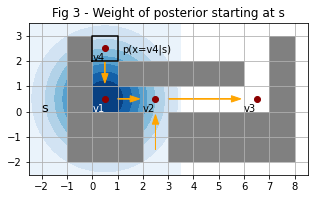

In [7]:
fig, ax = plt.subplots(figsize=(5,5))

# building layout
building1 = plt.Rectangle((0,-2), 2, 2, fc='grey')
building2 = plt.Rectangle((1, 1), 5, 1, fc='grey')
building3 = plt.Rectangle((3, -2), 5, 2, fc='grey')
building4 = plt.Rectangle((7, 0), 1, 3, fc='grey')
building6 = plt.Rectangle((-1,-2), 1, 5, fc='grey')
plt.gca().add_patch(building1)
plt.gca().add_patch(building2)
plt.gca().add_patch(building3)
plt.gca().add_patch(building4)
plt.gca().add_patch(building6)

# one-way streets
plt.arrow(0.5, 2, 0, -0.5, head_width=0.25, color='orange')
# plt.arrow(8.5, 1, 0, 1, head_width=0.25, color='orange')
plt.arrow(2.5, -1.5, 0, 1, head_width=0.25, color='orange')
# plt.arrow(12.5, 0, 0, -1, head_width=0.25, color='orange')
plt.arrow(1, 0.5, 0.5, 0, head_width=0.25, color='orange')
plt.arrow(3, 0.5, 2.5, 0, head_width=0.25, color='orange')
# plt.arrow(9, 0.5, 2.5, 0, head_width=0.25, color='orange')

#plot gaussian distribution:
X, Y, pos = determine_points([0.5,0.5], 30, end=3)
Sigma = np.array([[2,0],[0,2]])
Z = multivariate_normal.pdf(pos, [0.5,0.5], Sigma)
plt.contourf(X, Y, Z, cmap='Blues')

# plot intersections/vertices
plt.plot([0, 1, 1, 0, 0],[2, 2, 3, 3, 2], color='black')
plt.scatter([0.5, 2.5, 6.5, 0.5], [0.5, 0.5, 0.5, 2.5], 
            c='darkred', marker='o')

# add annotation to the intersections/vertices
notes = ['v1', 'v2', 'v3', 'v4', 's', 'p(x=v4|s)']
locations = [(0, 0), (2, 0), (6, 0), (0, 2), (-2,0), (1.2, 2.35)]
for i, location in enumerate(locations):
    if i==0:
        plt.annotate(notes[i], location, color='white')
    elif i==4:
         plt.annotate(notes[i], location, size=13)
    else:
        plt.annotate(notes[i], location)

# final formatting
plt.grid()
plt.xticks(np.arange(-2, 9))
plt.yticks(np.arange(-2,4))
plt.title('Fig 3 - Weight of posterior starting at s')
plt.axis('scaled')
plt.savefig('figure_3_graph.png', dpi=550)
plt.show()

#### <u>Part 3 - State Transitions </u>

The transition probability of taking an action a from an A-MDP state s to another state s' is found by computing the posterior belief of each.

**Transition Function**:

$\text{(9)} \qquad T(s'|s,a)=\eta\cdot exp(-D_B(p(x|s,a),p(x|s'))$

 * $s'$: new augmented state
 * $\eta$: normalization factor
 * $D_B$: is the Bhattacharyya distance (measure of overlap of two distributions)

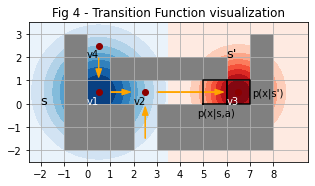

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

# building layout
building1 = plt.Rectangle((0,-2), 2, 2, fc='grey')
building2 = plt.Rectangle((1, 1), 5, 1, fc='grey')
building3 = plt.Rectangle((3, -2), 5, 2, fc='grey')
building4 = plt.Rectangle((7, 0), 1, 3, fc='grey')
building6 = plt.Rectangle((-1,-2), 1, 5, fc='grey')
plt.gca().add_patch(building1)
plt.gca().add_patch(building2)
plt.gca().add_patch(building3)
plt.gca().add_patch(building4)
plt.gca().add_patch(building6)

# one-way streets
plt.arrow(0.5, 2, 0, -0.5, head_width=0.25, color='orange')
# plt.arrow(8.5, 1, 0, 1, head_width=0.25, color='orange')
plt.arrow(2.5, -1.5, 0, 1, head_width=0.25, color='orange')
# plt.arrow(12.5, 0, 0, -1, head_width=0.25, color='orange')
plt.arrow(1, 0.5, 0.5, 0, head_width=0.25, color='orange')
plt.arrow(3, 0.5, 2.5, 0, head_width=0.25, color='orange')
# plt.arrow(9, 0.5, 2.5, 0, head_width=0.25, color='orange')

#plot gaussian distribution:
X, Y, pos = determine_points([0.5,0.5], 30, end=3)
Sigma = np.array([[2,0],[0,2]])
Z = multivariate_normal.pdf(pos, [0.5,0.5], Sigma)
plt.contourf(X, Y, Z, cmap='Blues')

X, Y, pos = determine_points([6.5,0.5], 30, end=3)
Sigma = np.array([[1,0],[0,1]])
Z = multivariate_normal.pdf(pos, [6.5,0.5], Sigma)
plt.contourf(X, Y, Z, cmap='Reds')

# plot intersections/vertices
plt.plot([6, 7, 7, 6, 6],[0, 0, 1, 1, 0], color='black')
plt.plot([5, 6, 6, 5, 5],[0, 0, 1, 1, 0], color='black')
plt.scatter([0.5, 2.5, 6.5, 0.5], [0.5, 0.5, 0.5, 2.5], 
            c='darkred', marker='o')

# add annotation to the intersections/vertices
notes = ['v1', 'v2', 'v3', 'v4', 's',"s'","p(x|s')","p(x|s,a)"]
locations = [(0, 0), (2, 0), (6, 0), (0, 2), (-2,0), (6,2), (7.1, 0.35), (4.75,-0.5) ]
for i, location in enumerate(locations):
    if i==0 or i==2:
        plt.annotate(notes[i], location, color='white')
    elif i==4 or i==5:
         plt.annotate(notes[i], location, size=13)
    else:
        plt.annotate(notes[i], location)

# final formatting
plt.grid()
plt.xticks(np.arange(-2, 9))
plt.yticks(np.arange(-2,4))
plt.title('Fig 4 - Transition Function visualization')
plt.axis('scaled')
plt.savefig('figure_4_graph.png', dpi=550)
plt.show()

### Step 5. Reward Function (R)

**Reward of taking action $a$ from $v_i$ to $v_j$**:

$\text{(10)} \qquad r(v_i,a,v_j) = -l(v_i, a, v_j) \qquad \text{(length function)}$

**If $v_k$ not reachable from $v_i$ through action $a$**:

$\text{(11)} \qquad r(v_i,a,v_k) = -r_{noroad}, \qquad \text{with } r_{noroad}>>0$

**If action $a$ brings $v_i$ to $v_goal$**:

$\text{(12)} \qquad r(v_i,a,v_{goal}) = r_{goal}-l(v_i, a, v_{goal}), \qquad \text{with } r_{goal} \geq 0$



**Combine rewards for overall reward function:**

$\text{(13)} \qquad R(s',a,s)=\sum_{i=1}^{|V|}\bigg( p(x=v_i|s) \cdot \sum_{j=1}^{|V|}p(x=v_j|s')\cdot r(v_i, a, v_j)\bigg)$